Animating oil dispersion on the Salish Sea Atlantis grid. Original code written by Bec Gordon & Javier Porobic, CSIRO, modified to create an animated GIF

In [50]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
from pathlib import Path
from pprint import pprint
from netCDF4 import Dataset
import matplotlib.cm as cm
from IPython.display import Image
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [26]:
# salish sea atlantis box shapefile.
shapefile_SSAM = Path("/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp")
data_df = gpd.read_file(shapefile_SSAM)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]

In [27]:
numBoxes = len(data_df.BOX_ID)
numLayers = 7
print(numBoxes)
print(numLayers)

130
7


In [28]:
file_id = int(input( ))
scenario = {1 : "5b_Turn_Point_Diluted_bitumen",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",
            4 : "4a_ActivePass_Diesel",}

print("\nScenario running  :", scenario[file_id], sep = " ")


Scenario running  : 5b_Turn_Point_Diluted_bitumen


In [42]:
scenarios = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/')
scenario_paths = sorted([p for p in scenarios.glob('Atlantis_' + str(scenario[file_id]) + '_*.nc')])
scenario_filenames = {'box': os.fspath(shapefile_SSAM),'depth': os.fspath(shapefile_SSAM),'data': scenario_paths}
dimensions = {'time': 't', 'box': 'b', 'depth': 'z'}

new_data = np.zeros((numBoxes))

pprint(scenario_filenames)

{'box': '/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp',
 'data': [PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/Atlantis_5b_Turn_Point_Diluted_bitumen_2018-01-01.nc'),
          PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/Atlantis_5b_Turn_Point_Diluted_bitumen_2019-01-06.nc'),
          PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/Atlantis_5b_Turn_Point_Diluted_bitumen_2019-01-13.nc'),
          PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/Atlantis_5b_Turn_Point_Diluted_bitumen_2020-01-12.nc'),
          PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/results/Atlantis_5b_Turn_Point_Diluted_bitumen_2020-01-19.nc')],
 'depth': '/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July17

In [31]:
netcdfFileName = "Probabilities_" + scenario[file_id] + ".nc"
try:
    os.remove(netcdfFileName)
except:
    pass
ncfile = Dataset(netcdfFileName, "w", format="NETCDF4", clobber=True)
Dataset.set_fill_on(ncfile)

# Dimensions
#time = ncfile.createDimension("t", None)
b = ncfile.createDimension("b", numBoxes)
#z = ncfile.createDimension("z", numLayers)

In [32]:
# Variables
#times = ncfile.createVariable("t",np.float64, ("t",))
oil = ncfile.createVariable("oil",np.float64,("b"))

oil.units = "kgOil/m^3"
oil.long_name = "Oil"

#times.units = "seconds since " + d
#times.dt = outputDT
#times.long_name = "time"

In [43]:
# TO DO
# 1. For each file in the folder
#    flatten the data in each file - sum all concentrations in each box across layer and time scenario_filenames['data']
# 2. 
for path in scenario_paths :
   oil_data = xr.open_dataset(str(path), decode_cf=True)
   oil_variable = np.ma.filled(oil_data.variables["oil"], np.nan) # [t,b]
   oil_per_box = oil_variable.sum(axis=0)
   new_data = new_data + oil_per_box

   break

np.histogram(new_data)  

(array([120,   3,   3,   0,   0,   0,   0,   1,   1,   2]),
 array([0.00000000e+00, 1.90653578e-05, 3.81307156e-05, 5.71960735e-05,
        7.62614313e-05, 9.53267891e-05, 1.14392147e-04, 1.33457505e-04,
        1.52522863e-04, 1.71588220e-04, 1.90653578e-04]))

In [46]:
oil = new_data

ncfile.close()

In [48]:
# Uncomment below if adding a log scale so the boxes show the proportion of contamination
# import matplotlib.colors as colors

_cmap = cm.coolwarm #winter #viridis #Paired
file_names = []

land_df = data_df.loc[land_boxes]
data_df['oil'] = oil / oil.max() * 100 #percentage of total oil
data_df.loc[land_boxes, 'oil'] = -10

ax = data_df.plot(figsize=(9, 15), column = 'oil', cmap=_cmap, 
    vmin=-1, vmax = 100,
    legend=True, legend_kwds={'label': "% total oil released"
    },)

land_df.plot(ax=ax, color='white')
#ax.scatter(plon, plat, s=10, color='lightgrey', zorder=20) #s=0.001
ax.set_title(str('Scenario:' + scenario[file_id]))
ax.set_facecolor('white')

#plt.tight_layout()
plot_name = 'Plot_Probs_' + scenario[file_id] + '.png'
plt.savefig(plot_name)
plt.close()

plot_name

'Plot_Probs_5b_Turn_Point_Diluted_bitumen.png'

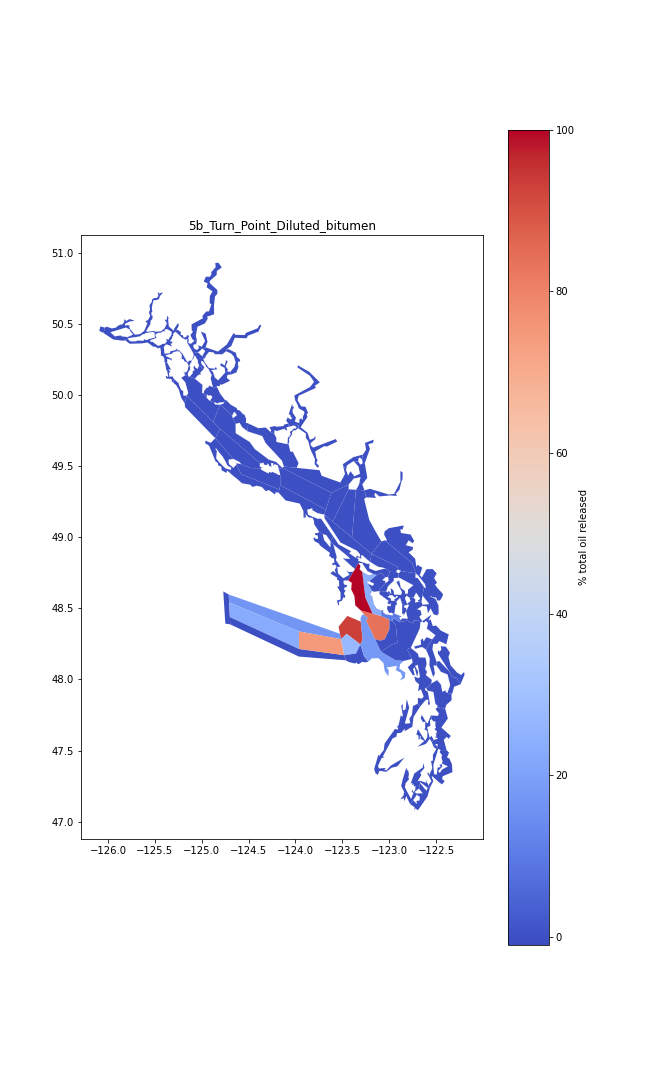

In [51]:
Image(plot_name)